In [3]:
from lib import utils
from lib import models
from lib import executor
from lib.utils import nearest_integer_acc

import torch
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

In [4]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = '../data_files/sha/ecq_sha_B_100_conds_1_500000_reg.parquet'

bsd_columns = ['rank', 'conductor', 'special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sha']
# Read the specified columns using PyArrow
table = pq.read_table(path, columns=bsd_columns)

# Convert the PyArrow Table to a Pandas DataFrame
df = table.to_pandas()

In [5]:
df['sha'].value_counts()

sha
1       2821178
4        158758
9         50428
16        18170
25         8501
36         2402
49         2153
64         1301
81          595
100         315
121         300
169         160
144         145
196          58
256          45
225          43
289          34
361          29
400          15
529          13
625          12
324           7
784           7
441           5
1024          4
576           4
729           4
676           3
961           3
841           3
484           2
1681          1
5625          1
2209          1
2500          1
1089          1
1849          1
1369          1
1156          1
Name: count, dtype: int64

In [6]:
df.head()

,rank,conductor,special_value,torsion,regulator,real_period,tamagawa_product,sha
0,0,11,0.25384,1,1.0,0.25384,1,1
1,0,11,0.25384,5,1.0,1.26921,5,1
2,0,11,0.25384,5,1.0,6.34605,1,1
3,0,14,0.33022,2,1.0,0.66045,2,1
4,0,14,0.33022,2,1.0,0.66045,2,1


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

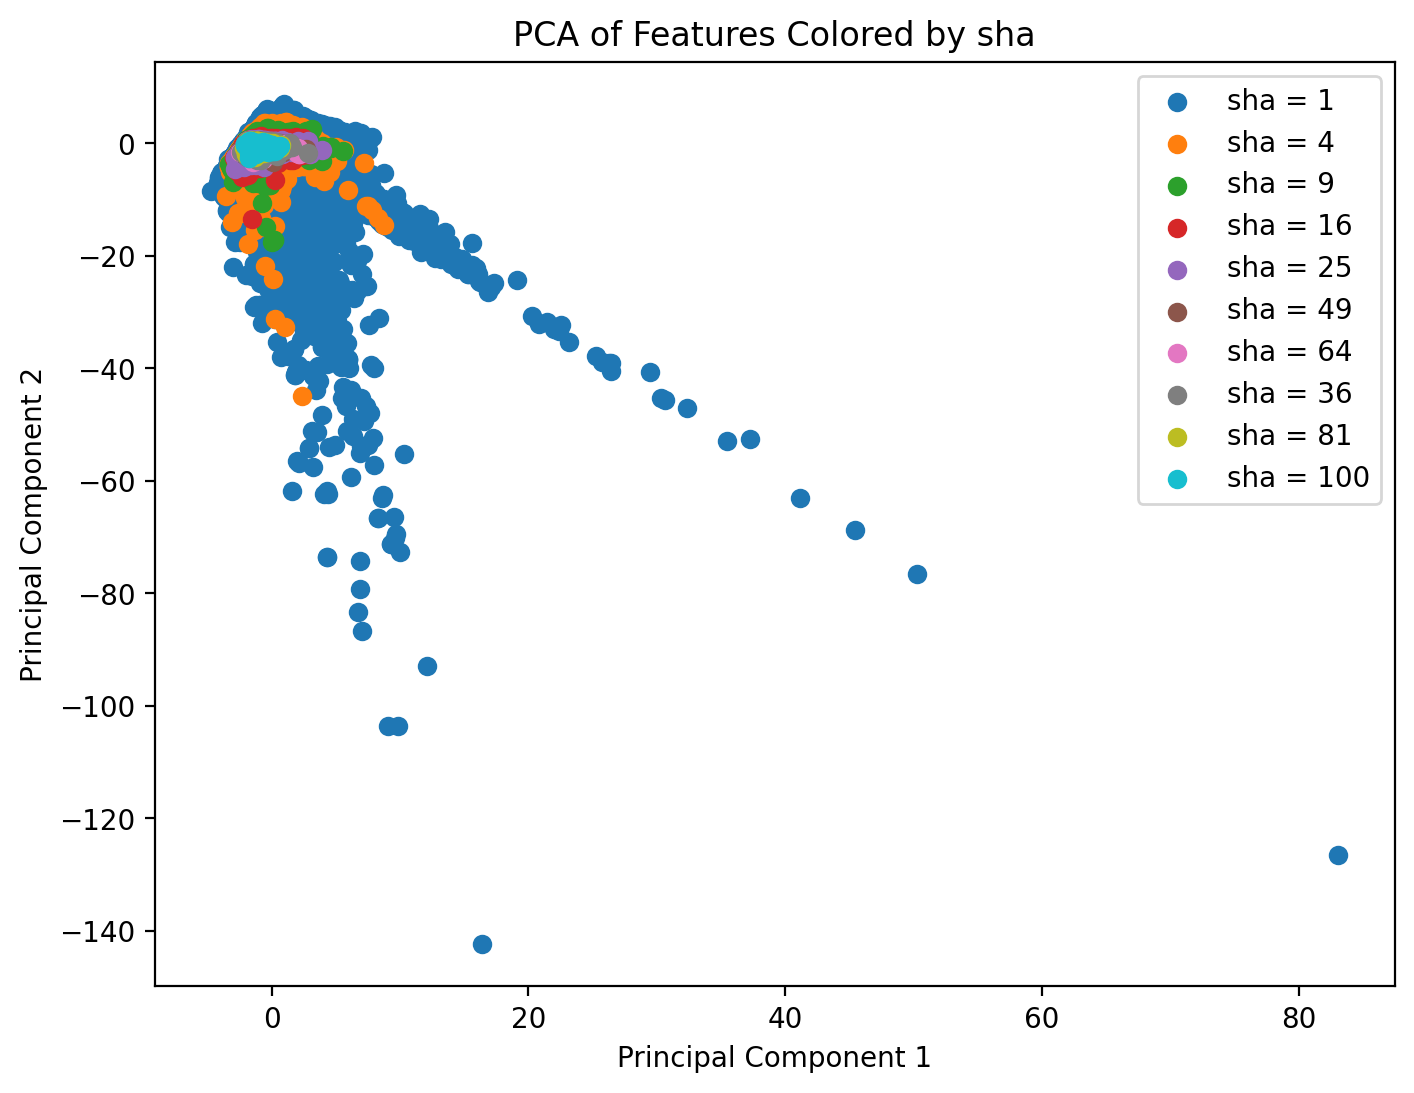

PCA Loadings:
                       PC1       PC2
tamagawa_product  0.054891 -0.488592
rank              0.653398  0.041912
conductor         0.197856 -0.303398
special_value     0.661104 -0.128973
torsion          -0.178066 -0.483496
regulator         0.174262 -0.265682
real_period       0.178266  0.588626


In [7]:
# Extract features and labels
features = ['tamagawa_product', 'rank', 'conductor', 'special_value', 'torsion', 'regulator', 'real_period']
X = df[features]
y = df['sha']

# Identify the top 10 classes by size
top_classes = y.value_counts().head(10).index

# Filter the dataset to include only the top 10 classes
filtered_df = df[df['sha'].isin(top_classes)]
X = filtered_df[features].copy()
y = filtered_df['sha'].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # Focus on the first two principal components
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA results
plt.figure(figsize=(8, 6))
for label in y.unique():
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'sha = {label}')
plt.title('PCA of Features Colored by sha')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Investigate loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("PCA Loadings:")
print(loadings)


In [14]:
df['sha_group'] = pd.cut(df['sha'], bins=[0, 10, 100, 10000], labels=['Low', 'Medium', 'High'])
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['sha_group'])
plt.title("PCA of Features Grouped by sha")
plt.show()

In [12]:
df['rank'].value_counts()

rank
1    1535669
0    1170876
2     348672
3       9487
4          1
Name: count, dtype: int64

Accuracy: 0.5013859408980637


/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    233861
           1       0.50      1.00      0.67    307320
           2       0.00      0.00      0.00     69826
           3       0.00      0.00      0.00      1933
           4       0.00      0.00      0.00         1

    accuracy                           0.50    612941
   macro avg       0.10      0.20      0.13    612941
weighted avg       0.25      0.50      0.33    612941



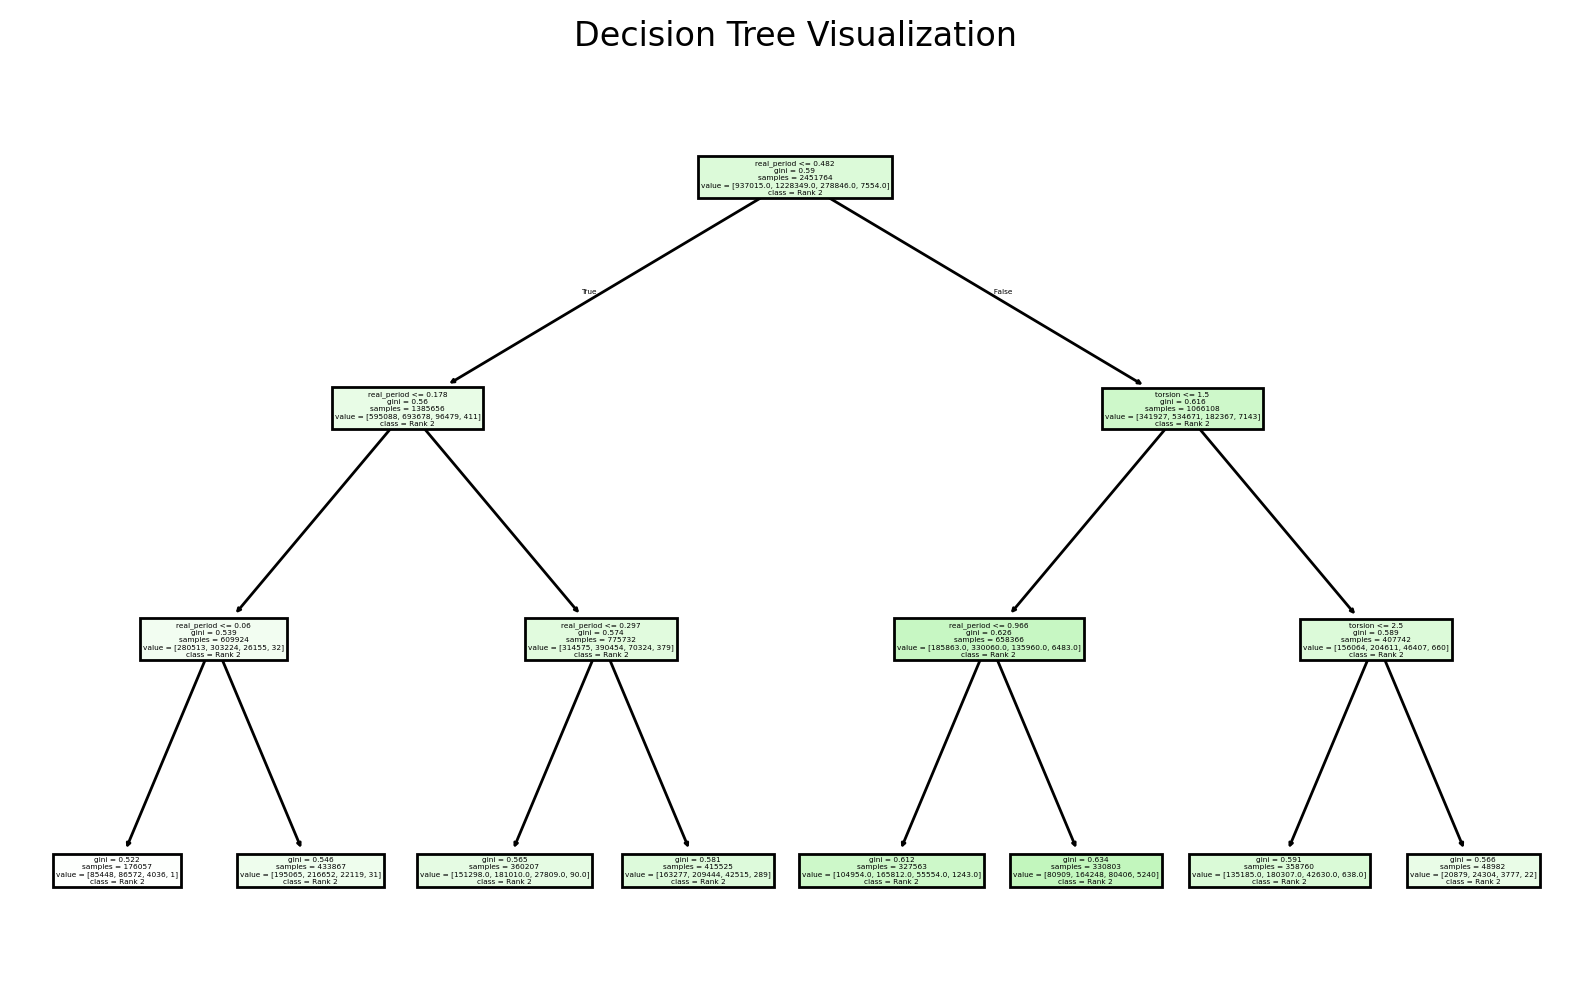

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Define features and target
X = df[['torsion', 'real_period']]
y = df['rank']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=['torsion', 'real_period'], class_names=['Rank 1', 'Rank 2', 'Rank 3'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature importance
importances = rf.feature_importances_
print("Feature Importances:", dict(zip(['torsion', 'real_period'], importances)))


Random Forest Accuracy: 0.47513382201549575


/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/sage/local/var/lib/sage/venv-python3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.43      0.40      0.42    233861
           1       0.52      0.61      0.57    307320
           2       0.23      0.11      0.15     69826
           3       0.04      0.02      0.03      1933
           4       0.00      0.00      0.00         1

    accuracy                           0.48    612941
   macro avg       0.25      0.23      0.23    612941
weighted avg       0.45      0.48      0.46    612941



Feature Importances: {'torsion': 0.010549971509196046, 'real_period': 0.989450028490804}


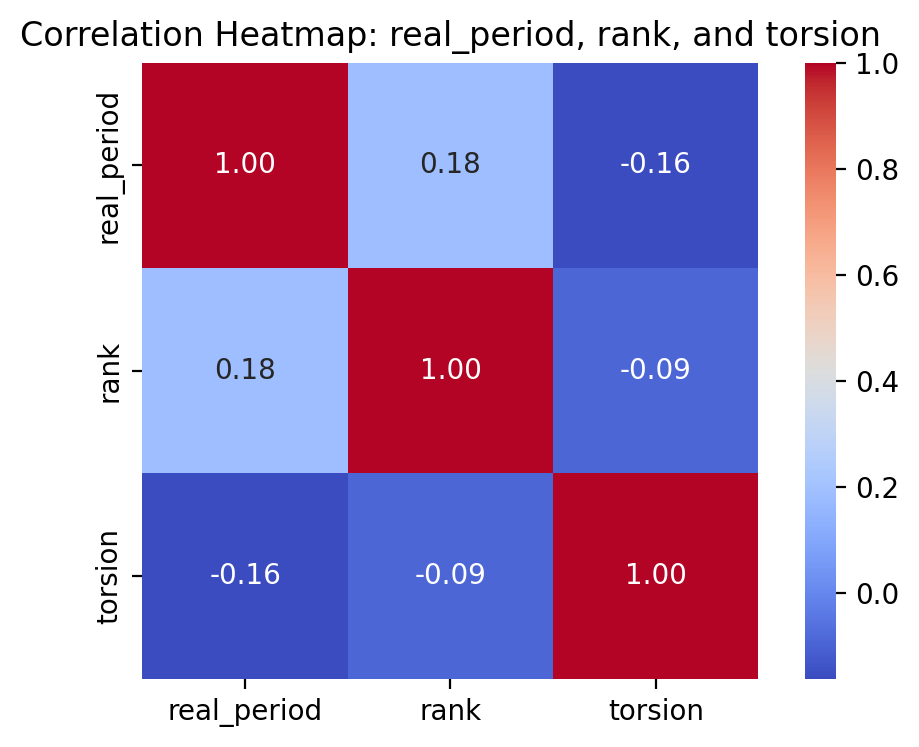

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df[['real_period', 'rank', 'torsion']].corr()

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", cbar=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap: real_period, rank, and torsion")
plt.show()

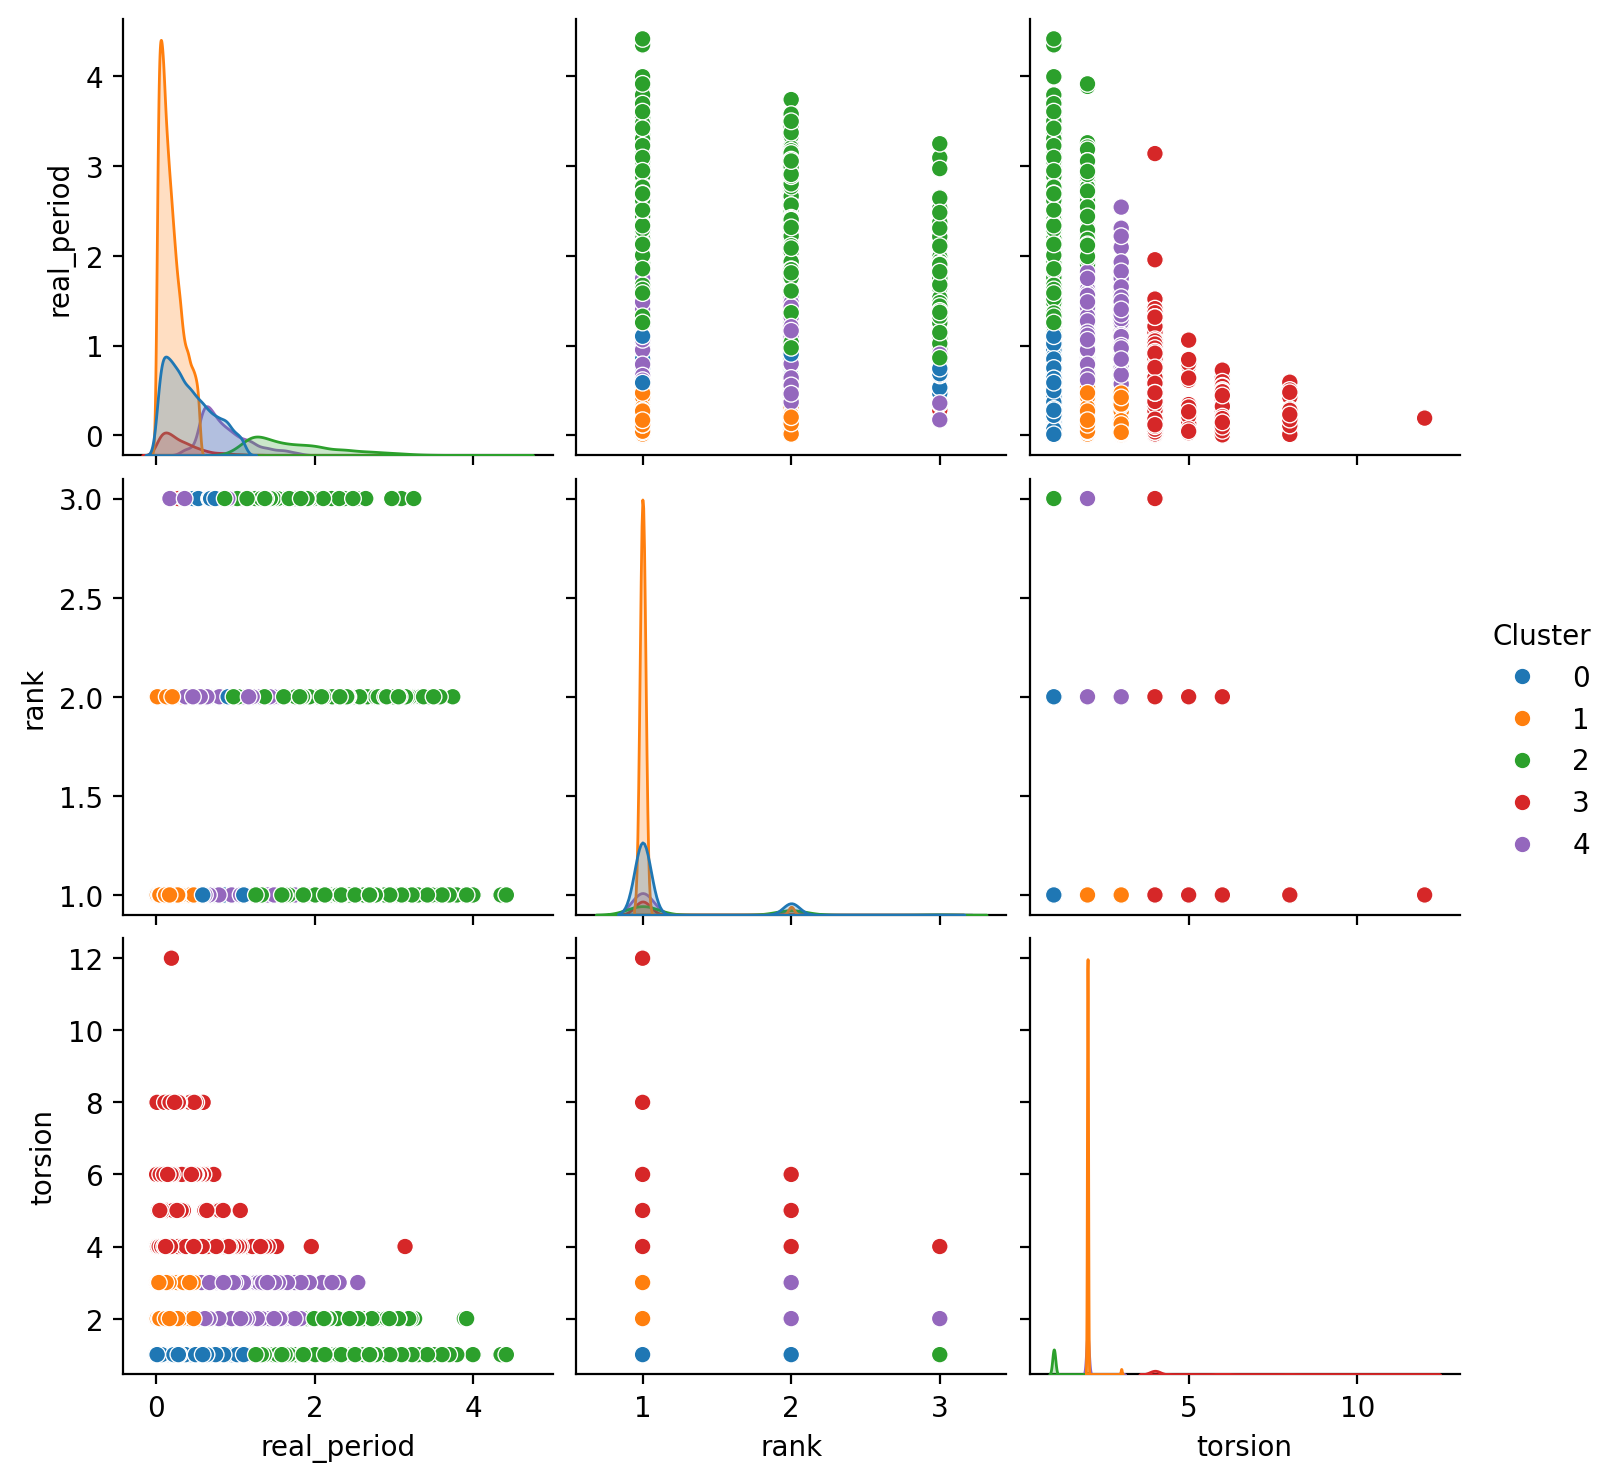

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features
X = df_balanced[['real_period', 'rank', 'torsion']]

# Perform K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
df_balanced['Cluster'] = kmeans.fit_predict(X)

# Visualize clusters
sns.pairplot(df_balanced, vars=['real_period', 'rank', 'torsion'], hue='Cluster', palette='tab10')
plt.show()

In [22]:
correlations = df_balanced.corr()
print(correlations['special_value'])

rank                0.258719
conductor           0.246658
special_value       1.000000
torsion            -0.031803
regulator           0.025147
real_period        -0.017403
tamagawa_product    0.120961
sha                 0.030097
Name: special_value, dtype: float64


In [23]:
correlations

,rank,conductor,special_value,torsion,regulator,real_period,tamagawa_product,sha
rank,1.000000,0.004457,0.258719,-0.165730,-0.030894,0.265980,0.029366,-0.320757
conductor,0.004457,1.000000,0.246658,-0.011310,0.042001,-0.150868,0.009983,0.126790
special_value,0.258719,0.246658,1.000000,-0.031803,0.025147,-0.017403,0.120961,0.030097
torsion,-0.165730,-0.011310,-0.031803,1.000000,0.035885,-0.269792,0.118903,0.319142
regulator,-0.030894,0.042001,0.025147,0.035885,1.000000,-0.122537,-0.024504,0.039164
real_period,0.265980,-0.150868,-0.017403,-0.269792,-0.122537,1.000000,-0.090057,-0.345632
tamagawa_product,0.029366,0.009983,0.120961,0.118903,-0.024504,-0.090057,1.000000,-0.077437
sha,-0.320757,0.126790,0.030097,0.319142,0.039164,-0.345632,-0.077437,1.000000


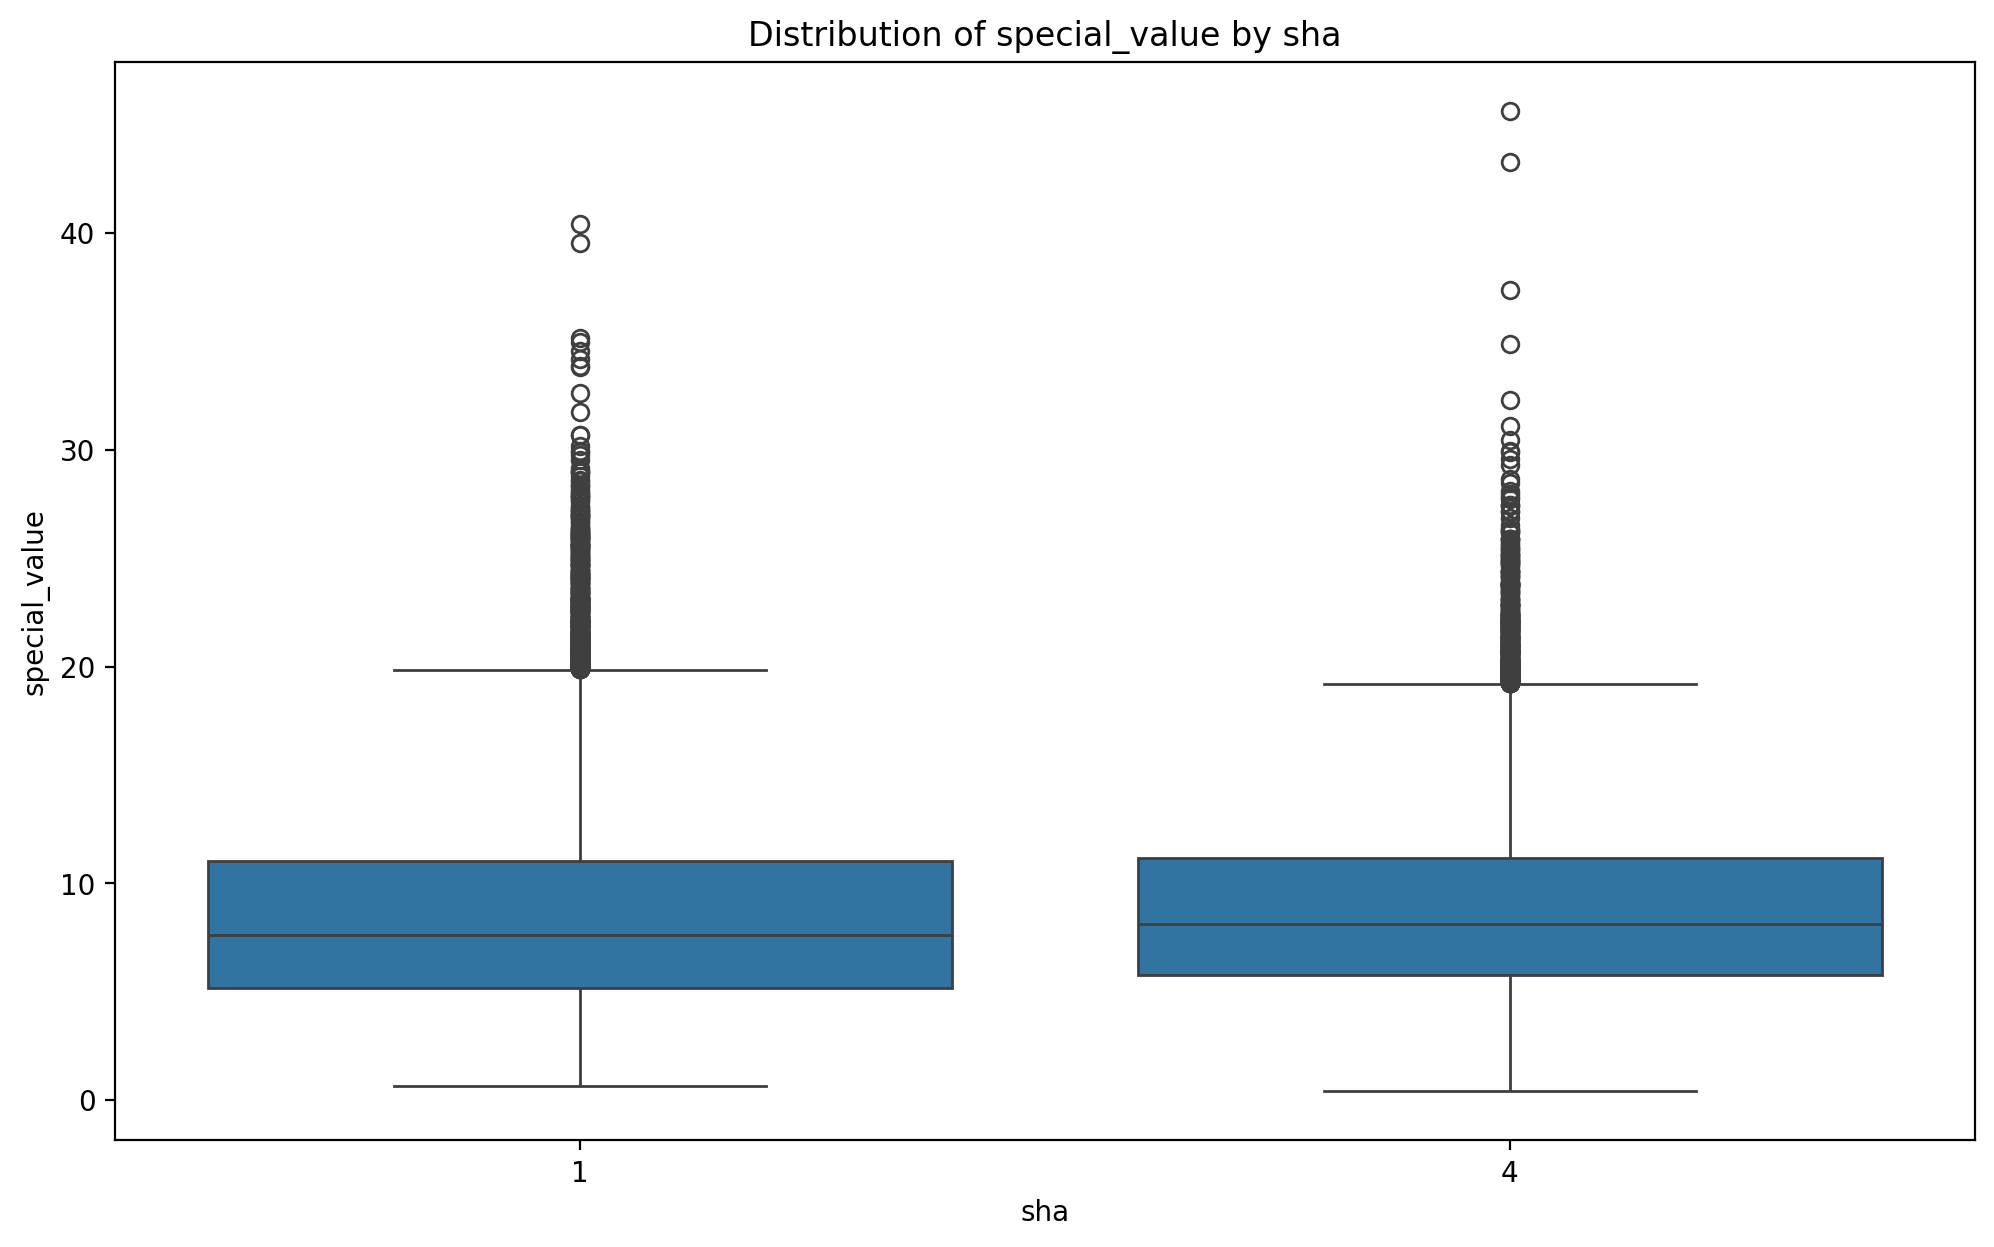

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='sha', y='special_value', data=df_balanced)
plt.title('Distribution of special_value by sha')
plt.show()


In [15]:
df_balanced.to_csv('tamagawa_investigation.csv', index=False)

In [6]:
bsd_features = ['special_value', 'torsion', 'real_period', 'regulator', 'tamagawa_product', 'sha']

df_balanced_bsd = df_balanced[bsd_features].copy()

In [7]:
df_balanced_bsd.head(5)

,special_value,torsion,real_period,regulator,tamagawa_product,sha
990015,0.91098,2,0.22775,1.00000,4,4
1738635,6.46522,1,0.35255,4.58456,1,4
1254341,4.56263,2,1.14066,1.00000,4,4
2932794,2.93596,1,0.09175,1.00000,8,4
1682714,6.31030,2,0.39439,1.00000,16,4


In [8]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Splitting features and target
X = df_balanced_bsd[['special_value', 'torsion', 'real_period', 'regulator', 'tamagawa_product']]
y = df_balanced_bsd['sha']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the LightGBM model
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 40429, number of negative: 40255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 80684, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501078 -> initscore=0.004313
[LightGBM] [Info] Start training from score 0.004313


Accuracy: 0.9831945270672219


In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a Histogram-based Gradient Boosting classifier
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.983739837398374
              precision    recall  f1-score   support

           4       0.98      0.99      0.98     10173
           9       0.99      0.98      0.98      9999

    accuracy                           0.98     20172
   macro avg       0.98      0.98      0.98     20172
weighted avg       0.98      0.98      0.98     20172



In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Log transform the dataframe
df_log_transformed = df_balanced_bsd.apply(np.log)

# Convert the log-transformed 'sha' column back to categorical labels
df_log_transformed['sha'] = df_balanced_bsd['sha']

# Splitting features and target
X = df_log_transformed[['special_value', 'torsion', 'real_period', 'regulator', 'tamagawa_product']]
y = df_log_transformed['sha']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy score
print("Accuracy:", accuracy)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Log transform the dataframe
df_log_transformed = df_balanced_bsd.apply(np.log)

# Splitting features and target
X = df_log_transformed[['special_value', 'torsion', 'real_period', 'regulator', 'tamagawa_product']]
y = df_log_transformed['sha']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Display the mean squared error
print("Mean Squared Error:", mse)

In [0]:
# Display the linear regression equation coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Display the equation
equation = "y = {:.4f} + ".format(model.intercept_)
equation += " + ".join(["{:.4f} * {}".format(coef, feature) for coef, feature in zip(model.coef_, X.columns)])
print("Linear Regression Equation:", equation)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Log transform the dataframe
df_log_transformed = df_balanced_bsd.apply(np.log)

# Convert the log-transformed 'sha' column back to categorical labels
df_log_transformed['sha'] = df_balanced_bsd['sha']

# Splitting features and target
X = df_log_transformed[['special_value', 'torsion', 'real_period', 'tamagawa_product']]
y = df_log_transformed['sha']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy score
print("Accuracy:", accuracy)

In [0]:
bsd_features = ['special_value', 'torsion', 'real_period', 'tamagawa_product', 'sha']
from sage.all import prime_range
B = 12

df_balanced_trunc = df_balanced[[str(p) for p in prime_range(B)] + bsd_features]

In [0]:
df_balanced_bsd_no_reg = df_balanced_bsd[['special_value', 'torsion', 'real_period', 'tamagawa_product', 'sha']].copy()

In [0]:
df_balanced_trunc.head(5)

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Set the desired GPU (e.g., GPU 2)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Set CUDA_LAUNCH_BLOCKING for debugging
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load the dataframe with df_balanced_bsd_no_reg
df_balanced_bsd_no_reg = df_balanced_bsd_no_reg.copy()

# Log transform the feature columns but leave the label as-is
columns_to_log_transform = ['special_value', 'torsion', 'real_period', 'tamagawa_product']
df_log_transformed = df_balanced_bsd_no_reg.copy()
df_log_transformed[columns_to_log_transform] = df_log_transformed[columns_to_log_transform].apply(np.log)

# Splitting features and target
X = df_log_transformed[columns_to_log_transform]
y = df_log_transformed['sha']

# Map labels to range starting from 0
y = y.map({4: 0, 9: 1})

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Verify label values are in the correct range
print("Unique labels in training set:", y_train_tensor.unique())
print("Unique labels in test set:", y_test_tensor.unique())

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class VanillaNN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=False):
        super(VanillaNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.output_dim = output_dim
        self.if_dropout = if_dropout
        self.dropout_rate = dropout_rate
        self.if_batchnorm = if_batchnorm
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(self.input_dim, self.hidden_units[0]))

        # Hidden layers
        for i in range(1, len(self.hidden_units)):
            if self.if_batchnorm:
                self.layers.append(nn.BatchNorm1d(self.hidden_units[i-1]))
            if self.if_dropout:
                self.layers.append(nn.Dropout(self.dropout_rate))
            self.layers.append(nn.Linear(self.hidden_units[i-1], self.hidden_units[i]))

        # Output layer
        if self.if_batchnorm:
            self.layers.append(nn.BatchNorm1d(self.hidden_units[-1]))
        if self.if_dropout:
            self.layers.append(nn.Dropout(self.dropout_rate))
        self.layers.append(nn.Linear(self.hidden_units[-1], self.output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                x = torch.relu(x)
        x = self.layers[-1](x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_units = [128, 64, 32]
output_dim = len(y.unique())
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = VanillaNN(input_dim, hidden_units, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.to(device)

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())

# Display the accuracy score
print("Accuracy:", accuracy)

In [0]:
from torch.utils.tensorboard import SummaryWriter

# Load the dataframe with df_balanced_bsd_no_reg
df_balanced_trunc = df_balanced_trunc.copy()

# Log transform the feature columns but leave the label as-is
columns_to_log_transform = ['special_value', 'torsion', 'real_period', 'tamagawa_product']
df_log_transformed = df_balanced_trunc.copy()
df_log_transformed[columns_to_log_transform] = df_log_transformed[columns_to_log_transform].apply(np.log)

# Splitting features and target
X = df_log_transformed[columns_to_log_transform]
y = df_log_transformed['sha']

# Map labels to range starting from 0
y = y.map({4: 0, 9: 1})

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Verify label values are in the correct range
print("Unique labels in training set:", y_train_tensor.unique())
print("Unique labels in test set:", y_test_tensor.unique())

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class VanillaNN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=False):
        super(VanillaNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.output_dim = output_dim
        self.if_dropout = if_dropout
        self.dropout_rate = dropout_rate
        self.if_batchnorm = if_batchnorm
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(self.input_dim, self.hidden_units[0]))

        # Hidden layers
        for i in range(1, len(self.hidden_units)):
            if self.if_batchnorm:
                self.layers.append(nn.BatchNorm1d(self.hidden_units[i-1]))
            if self.if_dropout:
                self.layers.append(nn.Dropout(self.dropout_rate))
            self.layers.append(nn.Linear(self.hidden_units[i-1], self.hidden_units[i]))

        # Output layer
        if self.if_batchnorm:
            self.layers.append(nn.BatchNorm1d(self.hidden_units[-1]))
        if self.if_dropout:
            self.layers.append(nn.Dropout(self.dropout_rate))
        self.layers.append(nn.Linear(self.hidden_units[-1], self.output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                x = torch.relu(x)
        x = self.layers[-1](x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_units = [128, 64, 32]
output_dim = len(y.unique())
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = VanillaNN(input_dim, hidden_units, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up TensorBoard writer
writer = SummaryWriter(log_dir='runs/training_logs')

# Train the model
model.to(device)

for epoch in range(1000):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor).item()
        _, y_pred = torch.max(outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch + 1)
    writer.add_scalar('Loss/Test', test_loss, epoch + 1)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch + 1)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch + 1)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Close the TensorBoard writer
writer.close()

# Display the final accuracy score
print("Final Test Accuracy:", test_accuracy)

In [0]:
# Log transform only the specified columns
columns_to_log_transform = ['special_value', 'torsion', 'real_period', 'tamagawa_product', 'sha']
B = 10
df_balanced_trunc = df_balanced[[str(p) for p in prime_range(B)] + bsd_features].copy()

df_log_transformed = df_balanced_trunc.copy()
df_log_transformed[columns_to_log_transform] = df_log_transformed[columns_to_log_transform].apply(np.log)

# Convert the log-transformed 'sha' column back to categorical labels
df_log_transformed['sha'] = df_balanced_trunc['sha']

# Splitting features and target
X = df_log_transformed[[str(p) for p in prime_range(B)] + ['special_value', 'torsion', 'real_period', 'tamagawa_product']]
y = df_log_transformed['sha']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy score
print("Accuracy:", accuracy)

In [0]:
# dropping columns that are not needed
df.drop(['conductor','adelic_level'], axis=1, inplace=True)

# process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

In [0]:
# choose model parameters
hidden_units = [128,64,32]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced_bsd_no_reg, 'sha', if_regression=True)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=True).to(device)

# print model summary
utils.model_summary(model)

In [0]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 30
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = perfect_square_acc

In [0]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced_bsd_no_reg, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [0]:
utils.plot_train_loss_hist(train_loss_hist, val_loss_hist)

In [0]:
acc = executor.test(model, test_dataset, evaluator, if_regression = True)
mae = executor.test(model, test_dataset, mean_absolute_error, if_regression = True)
mse = executor.test(model, test_dataset, mean_squared_error, if_regression = True)
print(f"Test accuracy: {acc:0.4f}")
print(f"Test Mean Absolute Error: {mae:0.4f}. Test Mean Squared Error: {mse:0.4f}")